In [112]:
import pandas as pd
import numpy as np
import sklearn
import math
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression, LassoCV
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.base import clone
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from imblearn.over_sampling import SMOTE
from numbers import Number
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, log_loss, roc_curve, roc_auc_score, ConfusionMatrixDisplay, confusion_matrix, RocCurveDisplay, classification_report
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.impute import MissingIndicator, SimpleImputer
from sklearn.compose import ColumnTransformer

In [13]:
test = pd.read_csv("../data/test_set_features.csv")
train_feat = pd.read_csv("../data/training_set_features.csv")
train_labels = pd.read_csv("../data/training_set_labels.csv")

In [14]:
train_full = pd.merge(train_feat, train_labels, on='respondent_id', how='inner')
train_full

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,...,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,h1n1_vaccine,seasonal_vaccine
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN,0,0
1,1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,...,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe,0,1
2,2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo,0,0
3,3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN,0,1
4,4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,...,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26702,26702,2.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,Own,Not in Labor Force,qufhixun,Non-MSA,0.0,0.0,NaN,NaN,0,0
26703,26703,1.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,Rent,Employed,lzgpxyit,"MSA, Principle City",1.0,0.0,fcxhlnwr,cmhcxjea,0,0
26704,26704,2.0,2.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,...,Own,NaN,lzgpxyit,"MSA, Not Principle City",0.0,0.0,NaN,NaN,0,1
26705,26705,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,...,Rent,Employed,lrircsnp,Non-MSA,1.0,0.0,fcxhlnwr,haliazsg,0,0


In [15]:
train_full.isna().sum()

respondent_id                      0
h1n1_concern                      92
h1n1_knowledge                   116
behavioral_antiviral_meds         71
behavioral_avoidance             208
behavioral_face_mask              19
behavioral_wash_hands             42
behavioral_large_gatherings       87
behavioral_outside_home           82
behavioral_touch_face            128
doctor_recc_h1n1                2160
doctor_recc_seasonal            2160
chronic_med_condition            971
child_under_6_months             820
health_worker                    804
health_insurance               12274
opinion_h1n1_vacc_effective      391
opinion_h1n1_risk                388
opinion_h1n1_sick_from_vacc      395
opinion_seas_vacc_effective      462
opinion_seas_risk                514
opinion_seas_sick_from_vacc      537
age_group                          0
education                       1407
race                               0
sex                                0
income_poverty                  4423
m

In [16]:
train_full = train_full.drop(columns=['respondent_id', 'health_insurance', 'employment_industry',
                                      'employment_occupation', 'hhs_geo_region'])
train_full

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,sex,income_poverty,marital_status,rent_or_own,employment_status,census_msa,household_adults,household_children,h1n1_vaccine,seasonal_vaccine
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,Female,Below Poverty,Not Married,Own,Not in Labor Force,Non-MSA,0.0,0.0,0,0
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,Male,Below Poverty,Not Married,Rent,Employed,"MSA, Not Principle City",0.0,0.0,0,1
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,...,Male,"<= $75,000, Above Poverty",Not Married,Own,Employed,"MSA, Not Principle City",2.0,0.0,0,0
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,Female,Below Poverty,Not Married,Rent,Not in Labor Force,"MSA, Principle City",0.0,0.0,0,1
4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,Female,"<= $75,000, Above Poverty",Married,Own,Employed,"MSA, Not Principle City",1.0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26702,2.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,Female,"<= $75,000, Above Poverty",Not Married,Own,Not in Labor Force,Non-MSA,0.0,0.0,0,0
26703,1.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,...,Male,"<= $75,000, Above Poverty",Not Married,Rent,Employed,"MSA, Principle City",1.0,0.0,0,0
26704,2.0,2.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,...,Female,NaN,Not Married,Own,NaN,"MSA, Not Principle City",0.0,0.0,0,1
26705,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,...,Female,"<= $75,000, Above Poverty",Married,Rent,Employed,Non-MSA,1.0,0.0,0,0


In [17]:
train_full=train_full.dropna()
train_full

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,sex,income_poverty,marital_status,rent_or_own,employment_status,census_msa,household_adults,household_children,h1n1_vaccine,seasonal_vaccine
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,Female,Below Poverty,Not Married,Own,Not in Labor Force,Non-MSA,0.0,0.0,0,0
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,Male,Below Poverty,Not Married,Rent,Employed,"MSA, Not Principle City",0.0,0.0,0,1
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,Female,Below Poverty,Not Married,Rent,Not in Labor Force,"MSA, Principle City",0.0,0.0,0,1
4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,Female,"<= $75,000, Above Poverty",Married,Own,Employed,"MSA, Not Principle City",1.0,0.0,0,0
5,3.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,Male,"<= $75,000, Above Poverty",Married,Own,Employed,"MSA, Principle City",2.0,3.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26700,3.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,...,Female,"> $75,000",Married,Own,Not in Labor Force,"MSA, Principle City",1.0,0.0,0,1
26701,2.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,Female,"> $75,000",Not Married,Rent,Not in Labor Force,"MSA, Principle City",3.0,0.0,0,0
26702,2.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,Female,"<= $75,000, Above Poverty",Not Married,Own,Not in Labor Force,Non-MSA,0.0,0.0,0,0
26703,1.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,...,Male,"<= $75,000, Above Poverty",Not Married,Rent,Employed,"MSA, Principle City",1.0,0.0,0,0


In [18]:
train_full.dtypes

h1n1_concern                   float64
h1n1_knowledge                 float64
behavioral_antiviral_meds      float64
behavioral_avoidance           float64
behavioral_face_mask           float64
behavioral_wash_hands          float64
behavioral_large_gatherings    float64
behavioral_outside_home        float64
behavioral_touch_face          float64
doctor_recc_h1n1               float64
doctor_recc_seasonal           float64
chronic_med_condition          float64
child_under_6_months           float64
health_worker                  float64
opinion_h1n1_vacc_effective    float64
opinion_h1n1_risk              float64
opinion_h1n1_sick_from_vacc    float64
opinion_seas_vacc_effective    float64
opinion_seas_risk              float64
opinion_seas_sick_from_vacc    float64
age_group                       object
education                       object
race                            object
sex                             object
income_poverty                  object
marital_status           

In [9]:
# dropped hhs_geo_region column
#train_full.hhs_geo_region

0        oxchjgsf
1        bhuqouqj
3        lrircsnp
4        qufhixun
5        atmpeygn
           ...   
26700    lzgpxyit
26701    fpwskwrf
26702    qufhixun
26703    lzgpxyit
26706    mlyzmhmf
Name: hhs_geo_region, Length: 19642, dtype: object

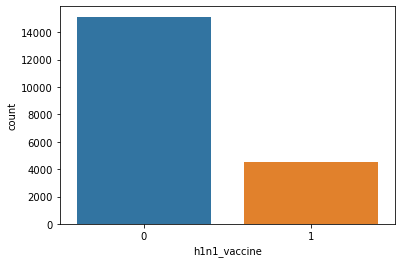

In [19]:
sns.countplot(x=train_full.h1n1_vaccine, data=train_full);

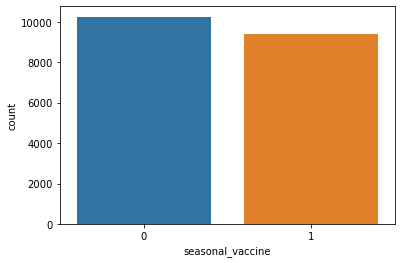

In [20]:
sns.countplot(x=train_full.seasonal_vaccine, data=train_full);

In [9]:
#numeric_col = ['h1n1_concern', 'h1n1_knowledge', 'behavioral_antiviral_meds', 'behavioral_avoidance',
#               'behavioral_face_mask', 'behavioral_wash_hands', 'behavioral_large_gatherings', 'behavioral_outside_home', 
#               'behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal', 'chronic_med_condition', 
#               'child_under_6_months', 'health_worker', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk', 
#               'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective', 'opinion_seas_risk', 
#               'opinion_seas_sick_from_vacc', 'household_adults', 'household_children'
#]
#
#cat_col = [
#    'age_group', 'education', 'race', 'sex', 'income_poverty', 'marital_status', 'rent_or_own', 
#    'employment_status', 'census_msa'
#]

Lol wut

In [21]:
ohe = OneHotEncoder()

object_columns = train_full.select_dtypes(include='object').columns
train_full = pd.get_dummies(train_full, columns=object_columns)
train_full

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,marital_status_Married,marital_status_Not Married,rent_or_own_Own,rent_or_own_Rent,employment_status_Employed,employment_status_Not in Labor Force,employment_status_Unemployed,"census_msa_MSA, Not Principle City","census_msa_MSA, Principle City",census_msa_Non-MSA
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0,1,1,0,0,1,0,0,0,1
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,0,1,0,1,1,0,0,1,0,0
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0,1,0,1,0,1,0,0,1,0
4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,1,0,1,0,1,0,0,1,0,0
5,3.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,1,0,1,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26700,3.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,...,1,0,1,0,0,1,0,0,1,0
26701,2.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0,1,0,1,0,1,0,0,1,0
26702,2.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0,1,1,0,0,1,0,0,0,1
26703,1.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0,1,0,1,1,0,0,0,1,0


In [60]:
X = train_full.drop("h1n1_vaccine", axis=1)
y = train_full["h1n1_vaccine"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33, random_state=42)

In [62]:
X_train.columns

Index(['h1n1_concern', 'h1n1_knowledge', 'behavioral_antiviral_meds',
       'behavioral_avoidance', 'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home',
       'behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal',
       'chronic_med_condition', 'child_under_6_months', 'health_worker',
       'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk',
       'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective',
       'opinion_seas_risk', 'opinion_seas_sick_from_vacc', 'household_adults',
       'household_children', 'seasonal_vaccine', 'age_group_18 - 34 Years',
       'age_group_35 - 44 Years', 'age_group_45 - 54 Years',
       'age_group_55 - 64 Years', 'age_group_65+ Years', 'education_12 Years',
       'education_< 12 Years', 'education_College Graduate',
       'education_Some College', 'race_Black', 'race_Hispanic',
       'race_Other or Multiple', 'race_White', 'sex_Female', 'sex_Male',
       'income_

### Dummy Model

In [63]:
# Dummy: always chooses majority
y.value_counts(normalize=True)

0    0.770186
1    0.229814
Name: h1n1_vaccine, dtype: float64

In [64]:
dummy_model = DummyClassifier(strategy="most_frequent")

In [65]:
# Fit dummy model onto our data
dummy_model.fit(X_train, y_train)

DummyClassifier(strategy='most_frequent')

In [66]:
# grabbing first 100 predictions
dummy_model.predict(X_train)[:100]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [67]:
y_train.value_counts(normalize=True)

0    0.767781
1    0.232219
Name: h1n1_vaccine, dtype: float64

In [68]:
dummy_model.score(X_train, y_train)

0.7677811550151976

Dummy model is ~76.9% accurate.

In [69]:
cv_results = cross_val_score(dummy_model, X_train, y_train, cv=5)
cv_results.mean()

0.7677811550151976

CV Results for `dummy` model:
            0.76778 ± 0.00037 accuracy
        


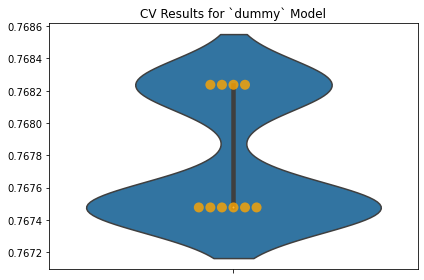

In [70]:
class ModelWithCV():
    '''Structure to save the model and more easily see its crossvalidation'''
    
    def __init__(self, model, model_name, X, y, cv_now=True):
        self.model = model
        self.name = model_name
        self.X = X
        self.y = y
        # For CV results
        self.cv_results = None
        self.cv_mean = None
        self.cv_median = None
        self.cv_std = None
        #
        if cv_now:
            self.cross_validate()
        
    def cross_validate(self, X=None, y=None, kfolds=10):
        '''
        Perform cross-validation and return results.
        
        Args: 
          X:
            Optional; Training data to perform CV on. Otherwise use X from object
          y:
            Optional; Training data to perform CV on. Otherwise use y from object
          kfolds:
            Optional; Number of folds for CV (default is 10)  
        '''
        
        cv_X = X if X else self.X
        cv_y = y if y else self.y

        self.cv_results = cross_val_score(self.model, cv_X, cv_y, cv=kfolds)
        self.cv_mean = np.mean(self.cv_results)
        self.cv_median = np.median(self.cv_results)
        self.cv_std = np.std(self.cv_results)

        
    def print_cv_summary(self):
        cv_summary = (
        f'''CV Results for `{self.name}` model:
            {self.cv_mean:.5f} ± {self.cv_std:.5f} accuracy
        ''')
        print(cv_summary)

        
    def plot_cv(self, ax):
        '''
        Plot the cross-validation values using the array of results and given 
        Axis for plotting.
        '''
        ax.set_title(f'CV Results for `{self.name}` Model')
        # Thinner violinplot with higher bw
        sns.violinplot(y=self.cv_results, ax=ax, bw=.4)
        sns.swarmplot(
                y=self.cv_results,
                color='orange',
                size=10,
                alpha= 0.8,
                ax=ax
        )

        return ax
    
dummy_model_results = ModelWithCV(
                        model=dummy_model,
                        model_name='dummy',
                        X=X_train, 
                        y=y_train
)

fig, ax = plt.subplots()

ax = dummy_model_results.plot_cv(ax)
plt.tight_layout();

dummy_model_results.print_cv_summary()

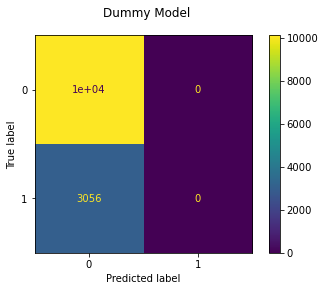

In [71]:
fig, ax = plt.subplots()

fig.suptitle("Dummy Model")

ConfusionMatrixDisplay(confusion_matrix(y_train, dummy_model.predict(X_train))).plot(ax=ax);

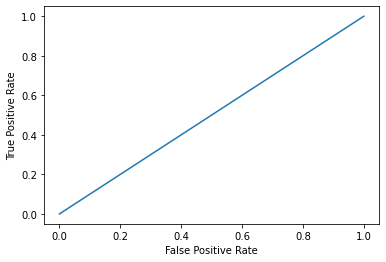

In [72]:
fpr, tpr, thresholds = roc_curve(y_train, dummy_model.predict_proba(X_train)[:,1])
RocCurveDisplay(fpr=fpr, tpr=tpr).plot();

In [73]:
dummy_model.predict_proba(X_train)

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])

In [74]:
X_train.shape, X_test.shape

((13160, 51), (6482, 51))

In [75]:
y_train.shape, y_test.shape

((13160,), (6482,))

In [76]:
tree_nodepth = DecisionTreeClassifier(random_state=42)
tree_depth = DecisionTreeClassifier(random_state=42, max_depth=2)
tree_nodepth.fit(X_train, y_train)
tree_depth.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=2, random_state=42)

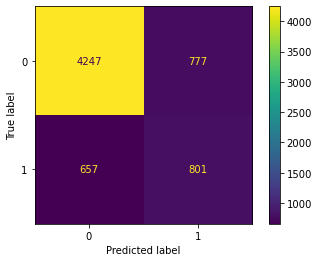

In [77]:
ConfusionMatrixDisplay(confusion_matrix(y_test, tree_nodepth.predict(X_test))).plot()

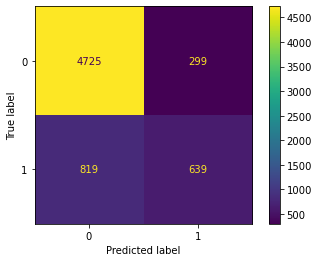

In [78]:
ConfusionMatrixDisplay(confusion_matrix(y_test, tree_depth.predict(X_test))).plot()
# test size = .33, max depth = 2, reduced FPs, still not great

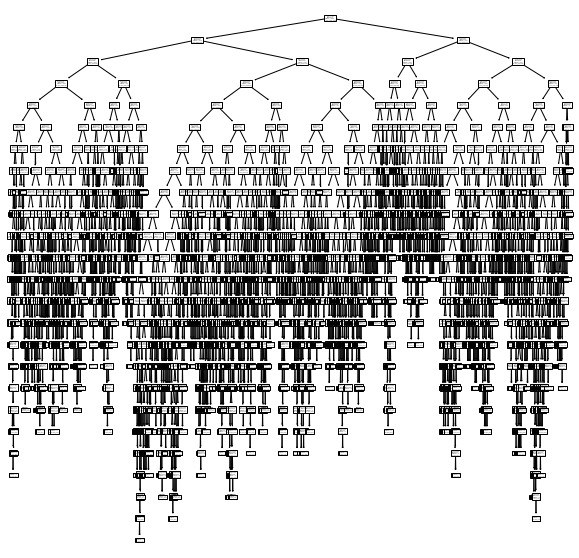

In [79]:
#f, ax = plt.subplots(figsize=(10, 10))
#plot_tree(tree_nodepth, ax=ax);

Horrifying.

In [80]:
y_pred = tree_nodepth.predict(X_test)
y_pred

array([0, 0, 0, ..., 0, 0, 1], dtype=int64)

In [81]:
accuracy_score(y_test, y_pred)

0.7787719839555692

In [94]:
precision_score(y_test, y_pred)

0.5076045627376425

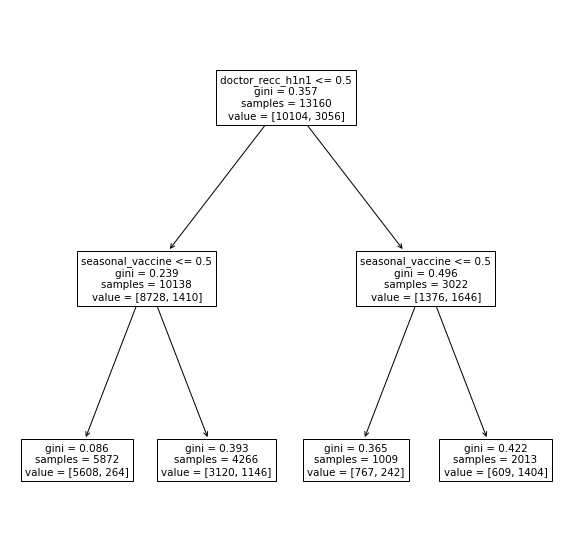

In [82]:
feature_used = X.columns.values
f, ax = plt.subplots(figsize=(10, 10))
plot_tree(tree_depth, ax=ax, feature_names=feature_used);

In [83]:
y_pred_depth = tree_depth.predict(X_test)
y_pred_depth

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [84]:
accuracy_score(y_test, y_pred_depth)

0.8275223696390003

In [85]:
precision_score(y_test, y_pred_depth)

0.6812366737739872

In [86]:
feature_used

array(['h1n1_concern', 'h1n1_knowledge', 'behavioral_antiviral_meds',
       'behavioral_avoidance', 'behavioral_face_mask',
       'behavioral_wash_hands', 'behavioral_large_gatherings',
       'behavioral_outside_home', 'behavioral_touch_face',
       'doctor_recc_h1n1', 'doctor_recc_seasonal',
       'chronic_med_condition', 'child_under_6_months', 'health_worker',
       'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk',
       'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective',
       'opinion_seas_risk', 'opinion_seas_sick_from_vacc',
       'household_adults', 'household_children', 'seasonal_vaccine',
       'age_group_18 - 34 Years', 'age_group_35 - 44 Years',
       'age_group_45 - 54 Years', 'age_group_55 - 64 Years',
       'age_group_65+ Years', 'education_12 Years',
       'education_< 12 Years', 'education_College Graduate',
       'education_Some College', 'race_Black', 'race_Hispanic',
       'race_Other or Multiple', 'race_White', 'sex_Female', 'sex_Male',
 

To SMOTE or not to SMOTE

In [95]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_sc = scaler.transform(X_train)
X_test_sc = scaler.transform(X_test)

In [97]:
sm = SMOTE(random_state=42)
# Fit and resample on the training data
X_train_smote, y_train_smote = sm.fit_resample(X_train_sc, y_train)

In [98]:
X_train_sc.shape

(13160, 51)

In [99]:
X_train_smote.shape

(20208, 51)

In [100]:
X_train_smote

array([[-0.69772188, -0.51875359, -0.23251855, ..., -0.8758736 ,
         1.55362427, -0.61271369],
       [-1.82352128,  1.16687536, -0.23251855, ...,  1.14171726,
        -0.64365627, -0.61271369],
       [ 1.55387692, -0.51875359, -0.23251855, ...,  1.14171726,
        -0.64365627, -0.61271369],
       ...,
       [ 0.42807752,  0.7376985 , -0.23251855, ..., -0.8758736 ,
        -0.64365627,  1.63208367],
       [-0.58258377,  1.16687536, -0.23251855, ..., -0.8758736 ,
        -0.53129579,  1.51729337],
       [ 0.42807752,  0.09573034, -0.23251855, ..., -0.8758736 ,
         1.55362427, -0.61271369]])

In [101]:
# train model with training data
smote_model1 = DecisionTreeClassifier(random_state=42)
smote_model1.fit(X_train_smote, y_train_smote)

DecisionTreeClassifier(random_state=42)

In [106]:
smote_model1.score(X_test_sc, y_test)

0.7796976241900648

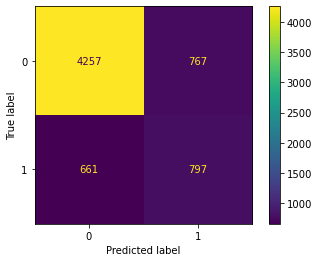

In [107]:
ConfusionMatrixDisplay(confusion_matrix(y_test, smote_model1.predict(X_test_sc))).plot();

In [109]:
accuracy_score(y_test, smote_model1.predict(X_test_sc))

0.7796976241900648

In [110]:
precision_score(y_test, smote_model1.predict(X_test_sc))

0.5095907928388747

In [113]:
# Feature selection from X

feature_names=X.columns.values

#fit model
clf = LassoCV().fit(X, y)

#Select features
importance = np.abs(clf.coef_)
idx_third = importance.argsort()[-3]
threshold = importance[idx_third] + 0.01
idx_features = (-importance).argsort()[:10]
name_features = np.array(feature_names)[idx_features]
print('Selected features: {}'.format(name_features))

Selected features: ['doctor_recc_h1n1' 'seasonal_vaccine' 'doctor_recc_seasonal'
 'health_worker' 'opinion_h1n1_risk' 'opinion_h1n1_vacc_effective'
 'child_under_6_months' 'sex_Female' 'behavioral_large_gatherings'
 'age_group_55 - 64 Years']


## Feature Selection on Full Data Sets

In [118]:
train_feat2 = pd.read_csv("../data/training_set_features.csv")
train_label2 = pd.read_csv("../data/training_set_labels.csv")

In [119]:
# OHE
ohe = OneHotEncoder()

object_columns = train_feat2.select_dtypes(include='object').columns
train_feat2 = pd.get_dummies(train_feat2, columns=object_columns)
train_feat2

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,...,employment_occupation_qxajmpny,employment_occupation_rcertsgn,employment_occupation_tfqavkke,employment_occupation_ukymxvdu,employment_occupation_uqqtjvyb,employment_occupation_vlluhbov,employment_occupation_xgwztkwe,employment_occupation_xqwwgdyp,employment_occupation_xtkaffoo,employment_occupation_xzmlyyjv
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0
1,1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,...,0,0,0,0,0,0,1,0,0,0
2,2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
3,3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26702,26702,2.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0
26703,26703,1.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
26704,26704,2.0,2.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,...,0,0,0,0,0,0,0,0,0,0
26705,26705,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,...,0,0,0,0,0,0,0,0,0,0


In [121]:
for col in train_feat2:
    train_feat2[col] = train_feat2[col].fillna(value=-1)

In [122]:
X2 = train_feat2
y2 = train_label2

feature_names2=train_feat.columns.values

#fit model
clf = LassoCV().fit(X2, y2)

#Select features
importance = np.abs(clf.coef_)
idx_third = importance.argsort()[-3]
threshold = importance[idx_third] + 0.01
idx_features = (-importance).argsort()[:10]
name_features = np.array(feature_names2)[idx_features]
print('Selected features: {}'.format(name_features))

ValueError: For multi-task outputs, use MultiTaskLassoCV

In [87]:
# note using numeric_df right now
#numeric_df.isna().sum()

In [88]:
#cat_df = train_full[cat_col]
#cat_df

In [89]:
# Imputers
#num_imput = SimpleImputer(add_indicator=True)
#cat_imput = SimpleImputer(strategy='constant', fill_value='Unknown', add_indicator=True)

# Pipelines
#num_pipeline = Pipeline(steps=[('impute_num', num_imput)])
#cat_pipeline = Pipeline(steps=[('impute_cat', cat_imput),
#                               ('ohe', OneHotEncoder(handle_unknown='ignore'))])

In [90]:
X_train.head()

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,marital_status_Married,marital_status_Not Married,rent_or_own_Own,rent_or_own_Rent,employment_status_Employed,employment_status_Not in Labor Force,employment_status_Unemployed,"census_msa_MSA, Not Principle City","census_msa_MSA, Principle City",census_msa_Non-MSA
10032,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,1,0,0,1,1,0,0,0,1,0
10719,0.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0,1,1,0,1,0,0,1,0,0
17069,3.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,...,0,1,1,0,1,0,0,1,0,0
23615,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,...,0,1,1,0,1,0,0,0,1,0
23931,2.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0,1,1,0,0,1,0,0,1,0


In [91]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13160 entries, 10032 to 21501
Data columns (total 51 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   h1n1_concern                              13160 non-null  float64
 1   h1n1_knowledge                            13160 non-null  float64
 2   behavioral_antiviral_meds                 13160 non-null  float64
 3   behavioral_avoidance                      13160 non-null  float64
 4   behavioral_face_mask                      13160 non-null  float64
 5   behavioral_wash_hands                     13160 non-null  float64
 6   behavioral_large_gatherings               13160 non-null  float64
 7   behavioral_outside_home                   13160 non-null  float64
 8   behavioral_touch_face                     13160 non-null  float64
 9   doctor_recc_h1n1                          13160 non-null  float64
 10  doctor_recc_seasonal          

In [92]:
#col_tr = ColumnTransformer(transformers=[('num', num_pipeline, numeric_col),
#                                        ('cat', cat_pipeline, cat_col)],
#                          remainder='passthrough', sparse_threshold=0)

In [93]:
#col_tr.fit_transform(X_train)